# WMA Charting Notebook

#### Packages and Tools

In [1]:
from utils.packages import *
from utils.tools import *
%matplotlib inline

#### Read from config file

In [2]:
temp_file = 'config/access_keys.yaml'
with open(temp_file) as temp_file:
    config = yaml.load(temp_file)
    
temp_file = 'config/wma.yaml'
with open(temp_file) as temp_file:
    wma = yaml.load(temp_file)    

In [3]:
instrument = wma['currency']['instrument']
short_moving_window = wma['wma']['short_moving_window']
long_moving_window = wma['wma']['long_moving_window']
lists_size = wma['wma']['lists_size']

access_token = config['oanda_demo_account']['token']
accountID = config['oanda_demo_account']['account_id']

#### Code Engine

In [4]:
seconds_elapsed, sec_per_iter, iter_counts, heart_beats, iter_per, heart_per = get_hit_speed(access_token, 
                                                                                             accountID, 
                                                                                             instrument, 
                                                                                             iter_limit = 3)

2it [00:07,  3.63s/it]

seconds_elapsed:7.0
sec_per_iter:4.0
iter_counts:2 --- iter_per:0.67
heart_beats:1 --- heart_per:0.33


KeyboardInterrupt: 

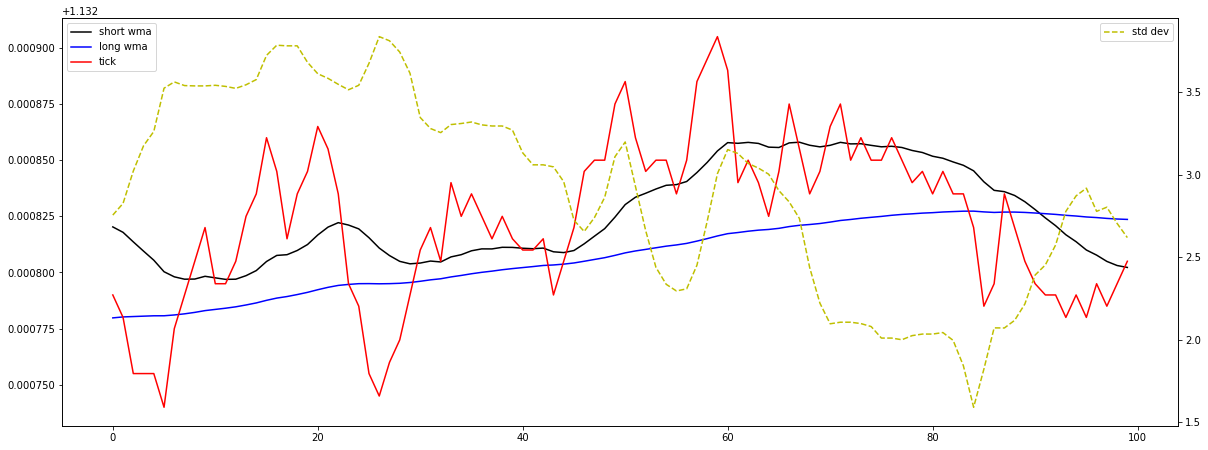

In [5]:
api = API(access_token = access_token)
params = {'instruments': instrument}
order_flag = 'not_ordered'
r = pricing.PricingStream(accountID=accountID, params=params)
rv = api.request(r)

short_wma = 0
short_flag = True
short_list = collections.deque([])
short_wma_list = collections.deque([])
short_weights = get_weights(short_moving_window)

stan_dev = 0
stan_dev_list = collections.deque([])

long_wma = 0
long_flag = True
long_list = collections.deque([])
long_wma_list = collections.deque([])
long_weights = get_weights(long_moving_window)

tick_list = collections.deque([])

start_time = time.time()
time_flag = True 
long_list_counter = 0

list_ready = False

for i, resp in enumerate(rv):        
    resp_type = resp['type']       

    # Heart beat response to keep the api connection alive (Avoid timeout)
    if resp_type == 'HEARTBEAT': 
        pass
    #-----------------------------------------------------------------------------------------------------
    
    
    # Price response 
    elif resp_type == 'PRICE': # Check if we are yet to make the order               
        
        #Decode values from response
        date_val, time_val, time_fraction = get_date_time(resp) # Get time stamp for reference            
        sell_price, buy_price, spread, tick_price = get_prices(resp) # Get prices from the response 
        #-----------------------------------------------------------------------------------------
        
        #Prepare short list to calculate WMA of shortwindows
        if len(short_list) < short_moving_window:
            short_list.append(tick_price)

        # Calculate wma for first iteration
        if short_flag and len(short_list) == short_moving_window:
            short_wma = sum(np.array(short_list)*short_weights)
            short_flag =  False

        # Calculate wma from the second iteration
        if short_flag == False and len(short_list) == short_moving_window:
            short_list.popleft()   
            short_list.append(tick_price) 
            short_wma = sum(np.array(short_list)*short_weights)
            stan_dev = statistics.stdev(short_list)
            stan_dev = stan_dev * 10**5

        # Append WMA list
        if len(short_list) == short_moving_window:
            if len(short_wma_list) < lists_size:
                short_wma_list.append(short_wma)
                stan_dev_list.append(stan_dev)

            elif len(short_wma_list) == lists_size:
                short_wma_list.popleft()   
                short_wma_list.append(short_wma) 
                
                stan_dev_list.popleft() 
                stan_dev_list.append(stan_dev)
                
        #print(f'short_wma_list : {len(short_wma_list)}')
        #-----------------------------------------------------------------------------------------
        
        
        #Prepare long list to calculate WMA of longwindows
        if len(long_list) < long_moving_window:
            long_list.append(tick_price)
            
         # Calculate wma for first iteration
        if long_flag and len(long_list) == long_moving_window:
            long_wma = sum(np.array(long_list)*long_weights)
            long_flag =  False

        # Calculate wma from the second iteration
        if long_flag == False and len(long_list) == long_moving_window:
            long_list.popleft()   
            long_list.append(tick_price) 
            long_wma = sum(np.array(long_list)*long_weights)

        # Append WMA list
        if len(long_list) == long_moving_window:
            if len(long_wma_list) < lists_size:
                long_wma_list.append(long_wma)
                tick_list.append(tick_price)

            # If WMA list reached required size start plotting
            elif len(long_wma_list) == lists_size:
                if time_flag:
                    end_time = time.time()    
                    duration = calc_duration(start_time, end_time)
                    time_flag = False
                    
                    df_wma = pd.DataFrame()
                    df_wma['seconds_elapsed'] = [seconds_elapsed]
                    df_wma['sec_per_iter'] = [sec_per_iter]
                    df_wma['iter_counts'] = [iter_counts]
                    df_wma['heart_beats'] = [heart_beats]
                    df_wma['iter_per'] = [iter_per]
                    df_wma['heart_per'] = [heart_per]
                    df_wma['short_moving_window'] = [short_moving_window]
                    df_wma['long_moving_window'] = [long_moving_window]
                    df_wma['lists_size'] = [lists_size]
                    df_wma['chart_duration'] = [duration]
                    df_wma.to_csv('data/machine_use/wma_chart.csv', mode='a', header=False, index = False)
                    winsound.PlaySound('C:\\Windows\\Media\\tada.wav', winsound.SND_ASYNC)           

                plt.close()
                long_wma_list.popleft()   
                long_wma_list.append(long_wma)  
                
                tick_list.popleft()   
                tick_list.append(tick_price)
                
                fig, ax1 = plt.subplots(1,1, figsize=(20,7.5))
                ax2 = ax1.twinx()

                ax1.plot(short_wma_list, 'k' ,label="short wma")
                ax1.plot(long_wma_list,'b' ,label="long wma")
                ax1.plot(tick_list, 'r' ,label="tick")
                ax2.plot(stan_dev_list,'y--' ,label="std dev")

                ax1.legend(loc="upper left")
                ax2.legend(loc="upper right")

                display.display(plt.gcf())
                display.clear_output(wait = True)                

In [6]:
df_copy = pd.read_csv('data/machine_use/wma_chart.csv')
df_copy.to_csv('data/wma_chart.csv', index = False)                        

In [10]:
df = pd.DataFrame({'tick_list':tick_list, 
                   'short_wma_list':short_wma_list, 
                   'stan_dev_list':stan_dev_list,
                   'long_wma_list':long_wma_list},
                  columns = ['tick_list', 'short_wma_list', 'long_wma_list','stan_dev_list'])

df.head()

,tick_list,short_wma_list,long_wma_list,stan_dev_list
0,1.132790,1.132820,1.132780,2.755752
1,1.132780,1.132818,1.132780,2.826511
2,1.132755,1.132814,1.132780,3.022554
3,1.132755,1.132810,1.132781,3.175820
4,1.132755,1.132805,1.132781,3.262412


In [ ]:
'''
from IPython.display import clear_output
import time

for i in range(10):
    clear_output(wait=True)
    time.sleep(1)
    print(i)    
'''